# North American Mushroom Ediblity Classification

(write problem understanding here)
(problem: want to determine rules for deciding if a mushroom is poisonous; should be easy to remember)

## Objectives
- Using Machine Learning, derive easy to remember/utilize decision rules to determine if a mushroom is poisonous
- Should not restrain from using high cardinality features (might be difficult to remember), or features where the levels are difficult to distinguish (unless it being difficult to distinguish does not matter e.g. two similar features tend to be poisonous anyways)
- Should not be overly complicated (easily interpretable by humans). Hence should refrain from using black box models, and limit the complexity. A absolutely perfect model that is overly complicated would be completely useless in the field.
- Should match or exceed human level performance. If perfect accuracy is not attainable, prioritize recall (mushroom is poisonous, but is wrongly classified as being edible). 
- Prioritize Tree based models which give a distinct answer rather than something like Logistic Regression which gives probabilistic outputs.
| Optimizing Metric | Satisficing Metrics |
|---|---|
| Accuracy | Model must be easily interpretable, preferably tree based model |
| | Max depth of tree based models < 10 |
| | Recall (True Positive Rate) > 98% |


### Defining Human Level Performance 
- We define human level performance to gain an estimate of the bayes optimal error, the best result attainable for a classification model.
- In a article published in Feburary 2020, the US Agricultural Research Service developed a portable test to detect if a mushroom is poisonous. https://www.mdpi.com/2072-6651/12/2/123/htm
- Hence, we define the target we want to match/exceed as the result of the test:

    | Accuracy | True Positive Rate | True Negative Rate |
    |----|----|----|
    | 94.6% | 92.3% | 100% |

In [309]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import json
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, RepeatedKFold, KFold
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, get_scorer, confusion_matrix, fbeta_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from yellowbrick.model_selection import learning_curve, feature_importances
from sklearn.inspection import permutation_importance

from sklearn.base import BaseEstimator, TransformerMixin
import phik # phi k correlation 
from phik.report import plot_correlation_matrix, correlation_report
sns.set()

from typing import Union, Tuple, List

In [6]:
dataframe = pd.core.frame.DataFrame

## Importing the Data 
The data format is a comma delimited file. The raw data is provided, without the column names provided as the first row. Hence, column names are manually specified based on the dataset info (`agaricus-lepiota.names`) file. From the dataset info, we also note that null values are denoted by the `?` symbol, and that there are 2480 missing values, all from the **stalk-root** column. 

In [7]:
col_names = [
    "class",
    "cap-shape",
    "cap-surface",
    "cap-color",
    "bruises?",
    "odor",
    "gill-attachment",
    "gill-spacing",
    "gill-size",
    "gill-color",
    "stalk-shape",
    "stalk-root",
    "stalk-surface-above-ring",
    "stalk-surface-below-ring",
    "stalk-color-above-ring",
    "stalk-color-below-ring",
    "veil-type",
    "veil-color",
    "ring-number",
    "ring-type",
    "spore-print-color",
    "population",
    "habitat"
]
mush_df = pd.read_csv("data/agaricus-lepiota.data", header=None, names = col_names, na_values="?")
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

### Improving Data Readability
Each attribute in the data is currently represented by a single letter. As this can make understanding the data more difficult, we will rename the attributes to be more human readable. I will import a mapping from each letter to the full name of the value.

In [8]:
with open('data/value_map.json') as json_file:
    value_map = json.load(json_file)
    mush_df = mush_df.replace(value_map)
mush_df.head()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,poisonous,convex,smooth,brown,t,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,edible,convex,smooth,yellow,t,almond,free,close,broad,black,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,edible,bell,smooth,white,t,anise,free,close,broad,brown,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,poisonous,convex,scaly,white,t,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,edible,convex,smooth,gray,f,none,free,crowded,broad,black,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses


## Data Understanding
We take reference from the Audubon Society Field Guide to North American Mushrooms, which is where the dataset was collected from, to understand what each feature represents.
### Odor

### Color
- A color guide is provided in the reference book.

### Spore Prints
- According to the reference book, spores of a mushroom are too small to be visible without a microscope
- Hence, seeing spore print color requires placing the mushroom on a piece of white paper, and seeing what color the paper turns
- This may take a long time (possibly hours), depending on the mushroom
- **Conclusion: Avoid, as much as possible, using any spore based features, as it is not practical to collect this data in the field.**


## Data Exploration

### Initial Questions for EDA
- Are the classes in the target label balanced?
- What does the frequency distribution for each categorical feature look like? 
- Are there any features with low variance (e.g. always the same value)?
- Are the missing values in the stalk-root column missing at random?
- Which categorical features have the high Cramer's V correlation with the target?
- What evaluation metric would be most suited for the data and problem?

In [9]:
mush_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises?                  8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                5644 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

In [10]:
mush_df.describe().T

,count,unique,top,freq
class,8124,2,edible,4208
cap-shape,8124,6,convex,3656
cap-surface,8124,4,scaly,3244
cap-color,8124,10,brown,2284
bruises?,8124,2,f,4748
odor,8124,9,none,3528
gill-attachment,8124,2,free,7914
gill-spacing,8124,2,close,6812
gill-size,8124,2,broad,5612
gill-color,8124,12,buff,1728


### Looking at Categorical Value Distributions
To make the task of checking out the count distribution of the different columns easier, I've created a function to automatically create a sorted countplot, further separated by the class if necessary.

In [11]:
def show_cat_dist(df: dataframe, columns: Union[List[str], str], hue: Union[str, None] = None, figsize: Tuple[float, float] = (7, 20)):
    fig, ax = plt.subplots(len(columns) if type(columns) is list else 1, 1, figsize=figsize, tight_layout=True)
    if type(columns) is list:
        for idx, feature in enumerate(columns):
            counts = df[feature].value_counts().sort_values(ascending=False)
            ax[idx].set_title("Categorical Distribution of " + feature)
            if hue is None:
        #         sns.catplot(data=df, y=column, kind='bar')
                sns.countplot(y=feature, data=df, order= counts.index, ax = ax[idx])
            else:
        #         sns.catplot(data=df, y=column, hue=hue, kind='bar')
                sns.countplot(y=feature, hue=hue,data=df,order=counts.index, ax = ax[idx])
    else:
            counts = df[columns].value_counts().sort_values(ascending=False)
            ax.set_title("Categorical Distribution of " + columns)
            if hue is None:
        #         sns.catplot(data=df, y=column, kind='bar')
                sns.countplot(y=columns, data=df, order= counts.index, ax = ax)
            else:
        #         sns.catplot(data=df, y=column, hue=hue, kind='bar')
                sns.countplot(y=columns, hue=hue,data=df,order=counts.index, ax = ax)
    return fig, counts


<AxesSubplot:xlabel='count', ylabel='class'>

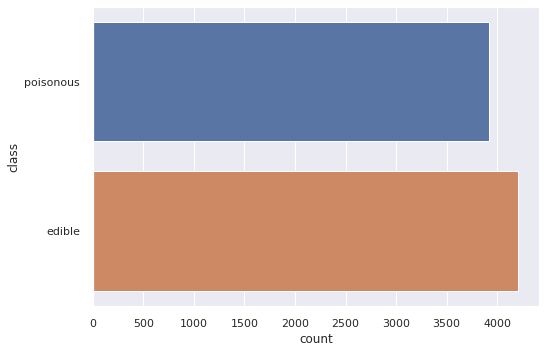

In [358]:
sns.countplot(data=mush_df, y="class")

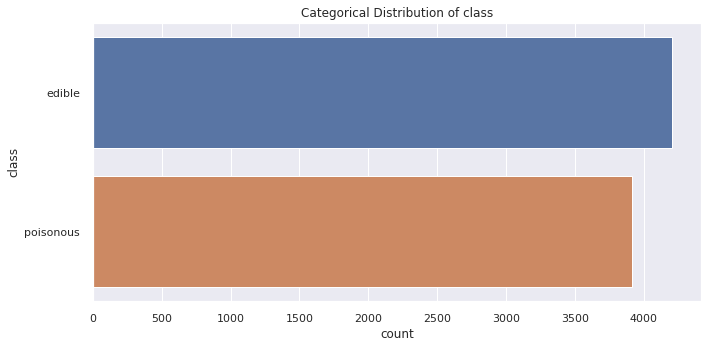

In [12]:
fig, counts = show_cat_dist(mush_df, "class", figsize=(10, 5))

In [13]:
mush_df["class"].value_counts()

edible       4208
poisonous    3916
Name: class, dtype: int64

In [14]:
4208 - 3916

292

There is a relatively even class balance between poisonous and edible mushrooms, with there being 292 more edible mushrooms in the entire dataset as compared to poisonous mushrooms. 

#### General Features

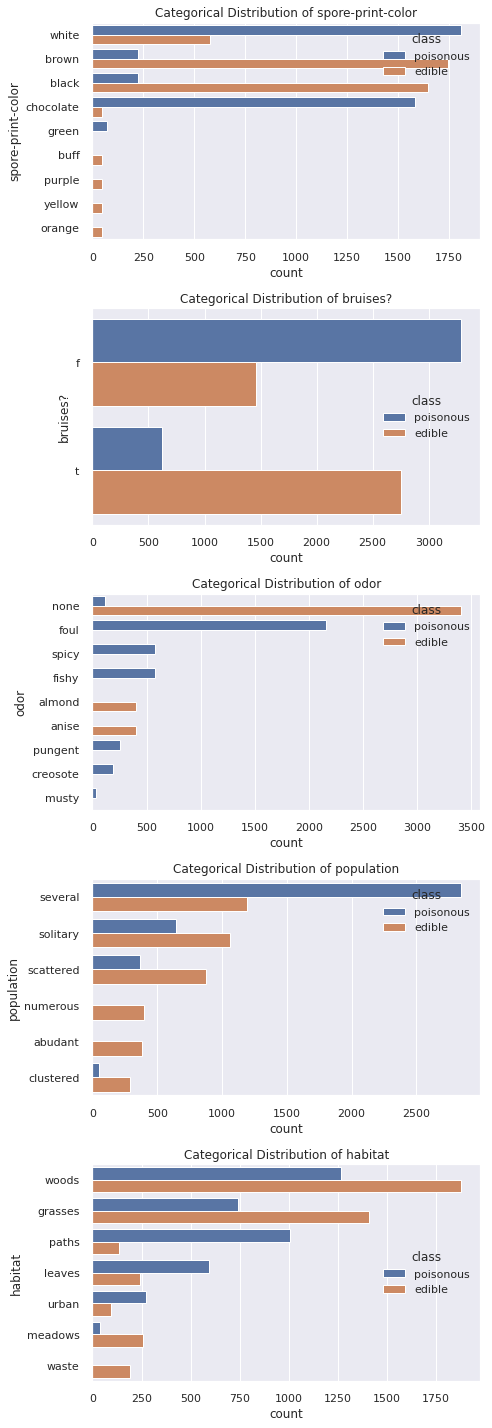

In [15]:
general_features = ['spore-print-color', 'bruises?', 'odor', 'population', 'habitat']

fig, counts = show_cat_dist(mush_df, general_features, "class")

fig.show()

#### Mushroom Cap Features

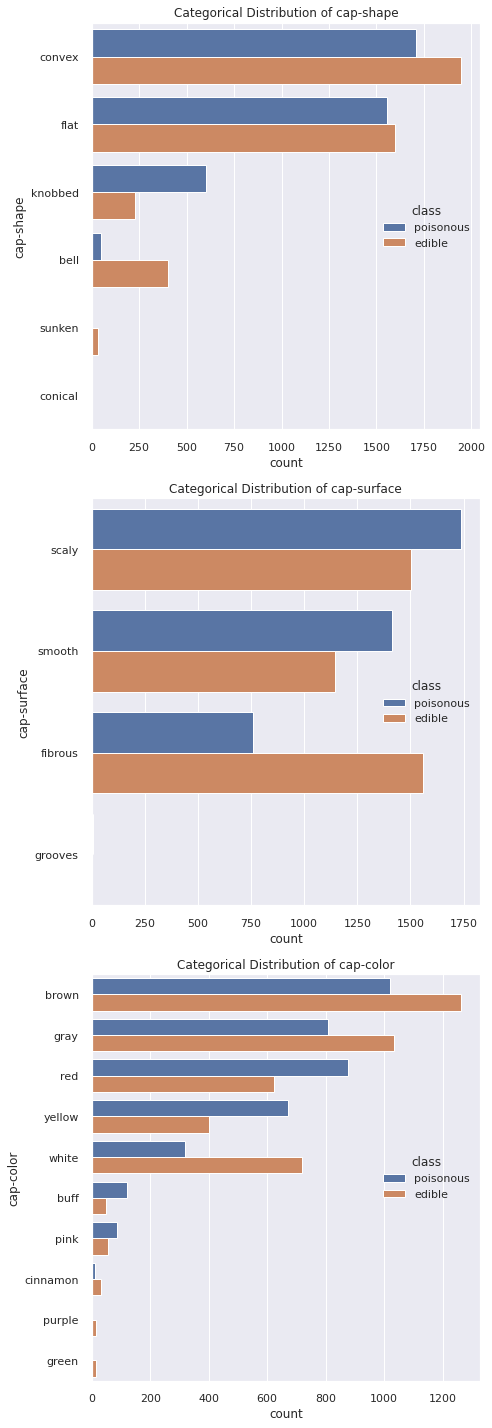

In [16]:
cap_features = ['cap-shape', 'cap-surface', 'cap-color']
fig, counts = show_cat_dist(mush_df, cap_features, "class")

fig.show()

#### Gill Features

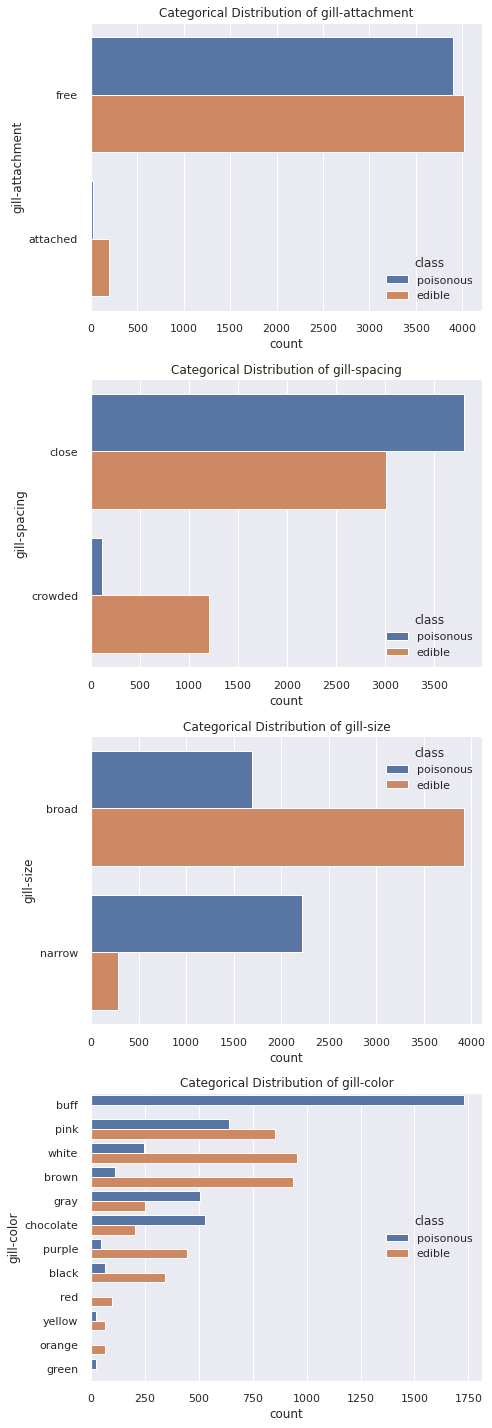

In [14]:
gill_features = ['gill-attachment', 'gill-spacing', 'gill-size', 'gill-color']
fig, counts = show_cat_dist(mush_df, gill_features, "class")

fig.show()

#### Stalk Features

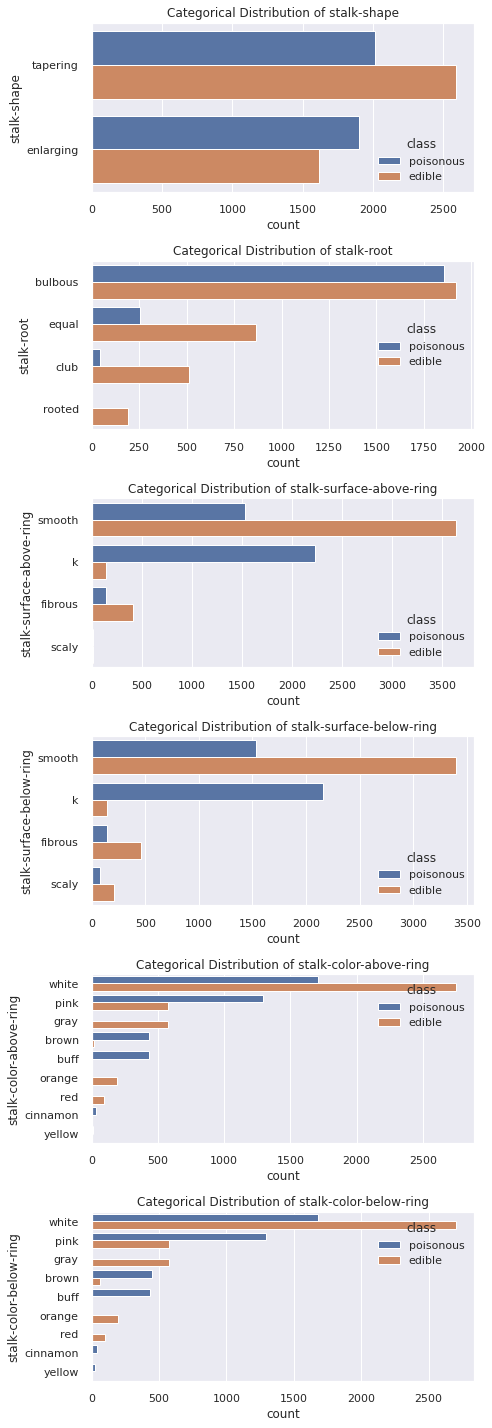

In [15]:
stalk_features = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring']
fig, counts = show_cat_dist(mush_df, stalk_features, "class")

fig.show()

#### Veil Features

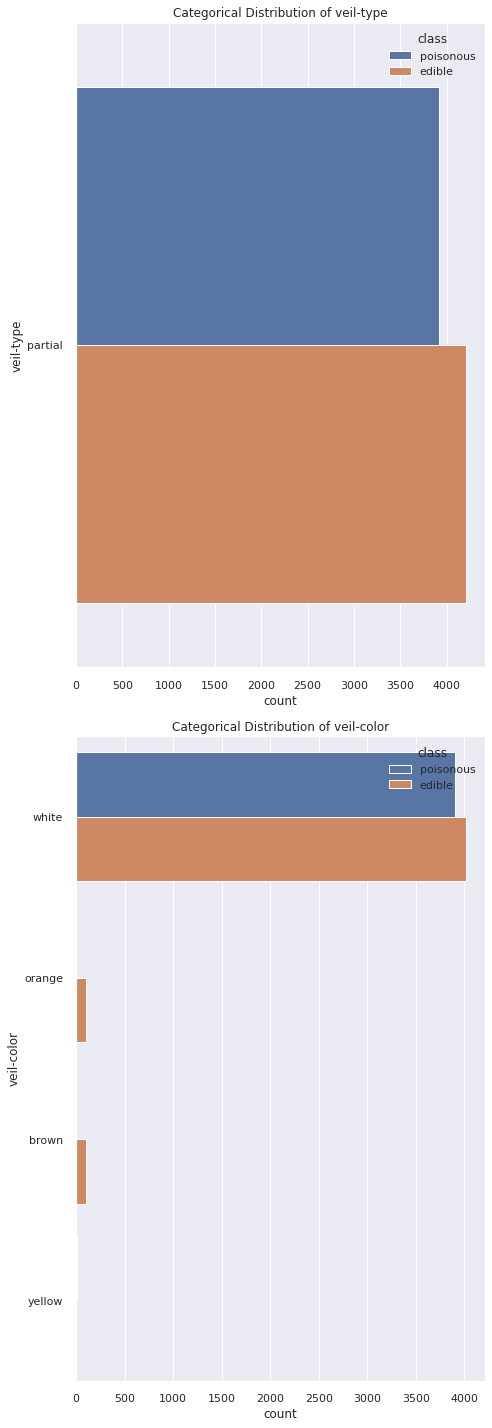

In [16]:
veil_features = ['veil-type', 'veil-color']
fig, counts = show_cat_dist(mush_df, veil_features, "class")

fig.show()

#### Ring Features

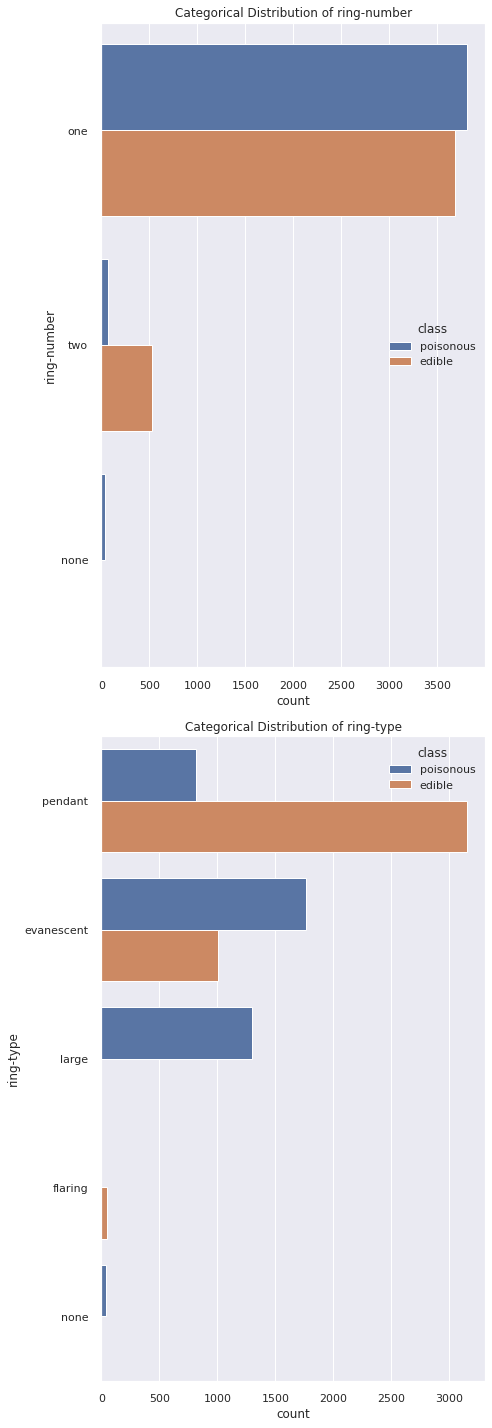

In [17]:
ring_features = ['ring-number',
       'ring-type']
fig, counts = show_cat_dist(mush_df, ring_features, "class")

fig.show()

#### Summary of Insights From Checking the Distribution of Categorical Variables

### Checking for Low Variance Features

For later feature selection, we wish to know which features almost always have the same value, as it would limit the usefulness of the feature.

In [18]:
mush_df.apply(lambda x : (x.value_counts() / len(mush_df) * 100).max(), axis = 0).sort_values(ascending=False)

veil-type                   100.000000
veil-color                   97.538159
gill-attachment              97.415066
ring-number                  92.171344
gill-spacing                 83.850320
gill-size                    69.079271
stalk-surface-above-ring     63.712457
stalk-surface-below-ring     60.758247
bruises?                     58.444116
stalk-shape                  56.720827
stalk-color-above-ring       54.948301
stalk-color-below-ring       53.963565
class                        51.797144
population                   49.729197
ring-type                    48.842935
stalk-root                   46.479567
cap-shape                    45.002462
odor                         43.426883
cap-surface                  39.931068
habitat                      38.749385
spore-print-color            29.394387
cap-color                    28.114229
gill-color                   21.270310
dtype: float64

In [381]:
pd.get_dummies(mush_df).corr()["class_poisonous"].abs().sort_values(ascending=False)

class_edible                      1.000000
class_poisonous                   1.000000
odor_none                         0.785557
odor_foul                         0.623842
stalk-surface-above-ring_k        0.587658
                                    ...   
cap-surface_grooves               0.023007
cap-shape_flat                    0.018526
stalk-root_bulbous                0.017712
stalk-surface-above-ring_scaly    0.016198
veil-type_partial                      NaN
Name: class_poisonous, Length: 118, dtype: float64

We observe that all mushrooms have the same veil type (also supported by our previous plots), and that most mushrooms have the same veil color, gill attachment, ring number and gill spacing.

### Checking Relationships Between Features and Target
To check correlation between the features and target, we make use of $\phi_k$ correlation, which has native support for nominal variables. The reason why we choose this over other measures of correlation like Pearson's r or $\chi^2$ is because:
- For a $\chi^2$ test, when the degrees of freedom is extremely high (as is the case when we have so many features), the chi squared values tend to be extremely large. Hence it becomes harder to interpret the values obtained as every feature would appear important.
- While Pearson correlation can calculate correlation between dichotomous categorical variables, it has been mostly designed for interval variables. To calculate correlation for nominal categorical variables, we need to one hot encode the data, which would make the resulting correlation plot extremely hard to read due to it's large size 

In [17]:
phik_overview = mush_df.phik_matrix().sort_values("class", ascending=False)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phik/data_quality.py:80: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  .format(col, df[col].nunique())


In [18]:
phik_overview.nlargest(10, "class")

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.339560,0.294330,0.281663,0.708427,0.931449,0.199636,0.519680,0.749777,0.838625,...,0.795807,0.783006,0.522229,0.512312,0.229215,0.129640,0.496840,0.737545,0.665121,0.410200
odor,0.931449,0.452134,0.358378,0.607339,0.653013,1.000000,0.260271,0.428422,0.744987,0.700349,...,0.583373,0.675120,0.862285,0.859799,0.155551,0.952736,0.846142,0.819423,0.630450,0.597233
gill-color,0.838625,0.524641,0.506619,0.568713,0.807167,0.700349,0.926703,0.416612,0.929546,1.000000,...,0.649711,0.680309,0.731246,0.727520,0.764312,0.723609,0.730589,0.787076,0.780714,0.719181
stalk-surface-above-ring,0.795807,0.242318,0.350663,0.407822,0.783349,0.583373,0.139788,0.628530,0.254215,0.649711,...,1.000000,0.839322,0.683801,0.601291,0.695746,0.134823,0.526466,0.586382,0.464642,0.417704
stalk-surface-below-ring,0.783006,0.168853,0.407656,0.495496,0.774913,0.675120,0.185772,0.600232,0.225441,0.680309,...,0.839322,1.000000,0.622198,0.631167,0.292244,0.267124,0.591786,0.589179,0.470218,0.429951
gill-size,0.749777,0.479438,0.412216,0.606414,0.547950,0.744987,0.168185,0.167915,1.000000,0.929546,...,0.254215,0.225441,0.364941,0.346026,0.169454,0.117523,0.469395,0.652801,0.702558,0.465152
spore-print-color,0.737545,0.460748,0.350068,0.545442,0.606991,0.819423,0.803236,0.307347,0.652801,0.787076,...,0.586382,0.589179,0.836237,0.832583,0.669123,0.653267,0.742690,1.000000,0.533221,0.543044
bruises?,0.708427,0.353524,0.200454,0.280636,1.000000,0.653013,0.212208,0.452514,0.547950,0.807167,...,0.783349,0.774913,0.481338,0.490808,0.199829,0.041795,0.639604,0.606991,0.415869,0.494364
population,0.665121,0.576710,0.390325,0.517833,0.415869,0.630450,0.570228,0.864630,0.702558,0.780714,...,0.464642,0.470218,0.680276,0.676804,0.342064,0.738902,0.470283,0.533221,1.000000,0.694694
stalk-color-above-ring,0.522229,0.401862,0.378182,0.530818,0.481338,0.862285,0.938937,0.399950,0.364941,0.731246,...,0.683801,0.622198,1.000000,0.949868,0.896146,0.963143,0.830963,0.836237,0.680276,0.651509


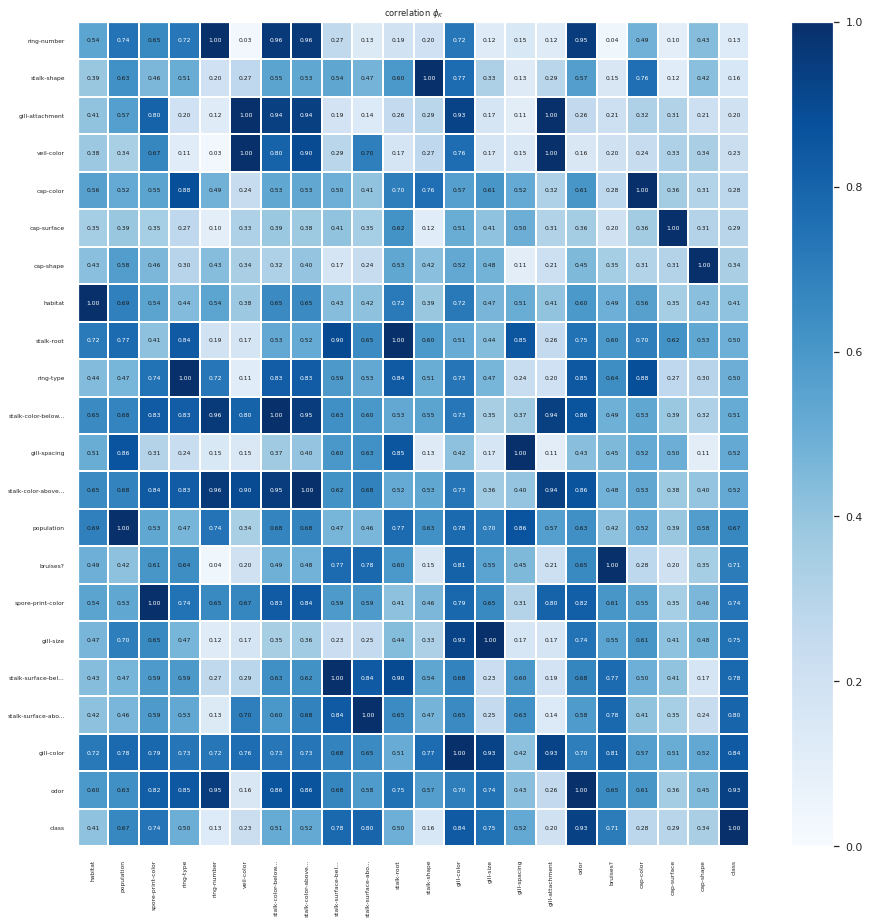

In [19]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=0.6,
                        figsize=(13,13))
plt.tight_layout()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phik/data_quality.py:80: UserWarning: Not enough unique value for variable veil-type for analysis 1. Dropping this column
  .format(col, df[col].nunique())
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/phik/phik.py:250: RuntimeWarning: invalid value encountered in sqrt
  global_correlations = np.array([[np.sqrt(1 - 1/(V[i][i] * Vinv[i][i]))] for i in range(V.shape[0])])


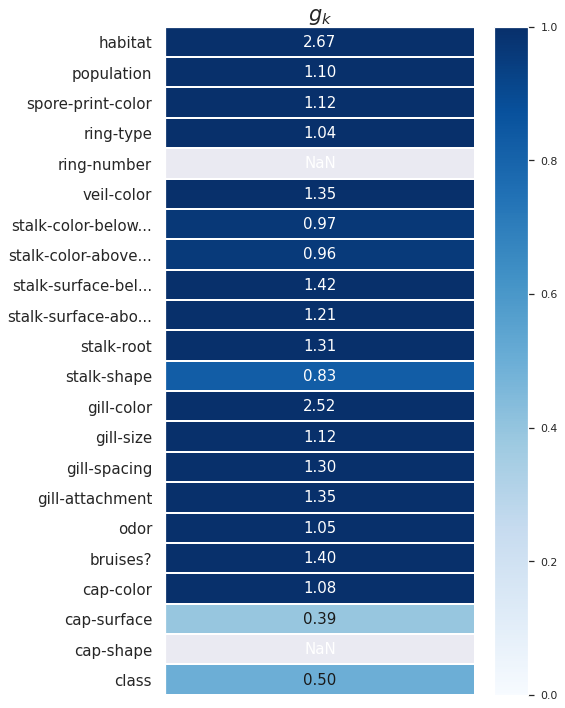

In [20]:
global_correlation, global_labels = mush_df.global_phik()
plot_correlation_matrix(global_correlation, x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(8,10),
                        color_map='Blues', title=r'$g_k$',
                        fontsize_factor=1.5)
plt.tight_layout()

## Data Preprocessing

### Separate Features and Labels
We start by separating the features and the labels. A label encoder is used to encode the labels as 1 (poisonous) and 0 (non-poisonous)

In [271]:
X, y = mush_df.drop('class', axis = 1), mush_df["class"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

### Splitting Data into Training and Test Set

In [272]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

### Data Preprocessing Pipeline: One-Hot Encoding

For our initial strategy, since all the features are nominal features, we one-hot encode them. Due to the high cardinality of some features, and the overall large number of features, this will greatly increase the dimensionality of our data. Hence, it may be necessary to perform feature selection later on to reduce the risk of overfitting due to the curse of dimensionality.

In [273]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')) # one hot encode categorical data. We don't drop for other catergorical features as we want to make the features more interpretible (at cost to having extra dimensions in the data)
]

## Modelling: Initial Baseline Model

In [352]:
from sklearn.dummy import DummyClassifier
clf = Pipeline(data_preprocess_steps + [
    ('Baseline Model', DummyClassifier(strategy="most_frequent"))
])

## Model Evaluation
To standardize the way the model is evaluated, we will create a function to automatically evaluate the model. 

In [353]:
# f_beta = make_scorer(fbeta_score, beta = 2)
def evalCandidateModel(model, X_train, y_train, scoring = ['f1', 'recall', 'accuracy'], decision_metric = 'f1', cv = RepeatedKFold(n_splits = 5, random_state = 0)):
#     fig, ax = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)
    single_metric = type(scoring) in {callable, str}
    if not single_metric:
        assert decision_metric in scoring
    scores = cross_validate(model, X_train, y_train, scoring=scoring, return_estimator=True, return_train_score=True, cv=cv)
    best_estimator = scores["estimator"][np.argmax(scores["test_score"]) if single_metric else np.argmax(scores[f"test_{decision_metric}"])]
    del scores["estimator"]
    scores = pd.DataFrame(scores)
      # If a hold out set is provided
#     if X_test is not None and y_test is not None:
#         scorer = get_scorer(scoring) # Then also score it, based off the scoring scheme provided
#         scores["hold_out_score"] = scorer(best_estimator, X_test, y_test)
#     y_pred = best_estimator.predict(X_test)
#     report = classification_report(y_test, y_pred)
#     matrix = confusion_matrix(y_test, y_pred)
#     plot_roc_curve(best_estimator, X_test, y_test, ax=ax[0, 1])
#     plot_precision_recall_curve(best_estimator, X_test, y_test, ax=ax[1, 1])

#     sns.heatmap(matrix, ax=ax[1, 0], annot=True, fmt="d")
#     ax[1, 0].set_xlabel("Predicted Value")
#     ax[1, 0].set_ylabel("Actual Value")
    lr = learning_curve(model, X_train, y_train, scoring = scoring if single_metric else decision_metric, n_jobs=-1, random_state = 42, cv =cv, show = False)
#     for axes in ax.flat:
#         axes.ticklabel_format(useOffset=False)
    return scores.describe().iloc[1:3, 2:].round(5), lr, best_estimator


In [354]:
def evalHistory(new_score, model_name, history = None):
    if history is None:
        history = pd.DataFrame()
    new_score =new_score.iloc[0, :]
    new_score.rename(index=model_name, inplace=True)
    history = history.append(new_score)
    return history

,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy
mean,0.0,0.0,0.0,0.0,0.51777,0.51777
std,0.0,0.0,0.0,0.0,0.01077,0.00269


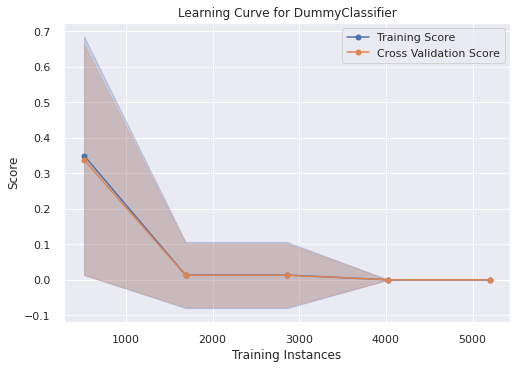

In [355]:
scores, fig, baseline = evalCandidateModel(clf, X_train, y_train)
history = evalHistory(scores, "Baseline (Mode Predictor)")
display(scores)

In [302]:
history

,test_accuracy,test_f1,test_recall,train_accuracy,train_f1,train_recall
Baseline (Mode Predictor),1.0,1.0,1.0,1.0,1.0,1.0


The baseline classifier is effectively equivalent to flipping a coin to decide if the mushroom is poisonous (random guessing), due to the relatively even class balance in the dataset.

## Modelling: Decision Tree

In [307]:
from sklearn.tree import DecisionTreeClassifier
dt = Pipeline(data_preprocess_steps + [
    ('Model', DecisionTreeClassifier())
])

,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy
mean,0.99995,1.0,0.99991,1.0,0.99995,1.0
std,0.00033,0.0,0.00066,0.0,0.00033,0.0


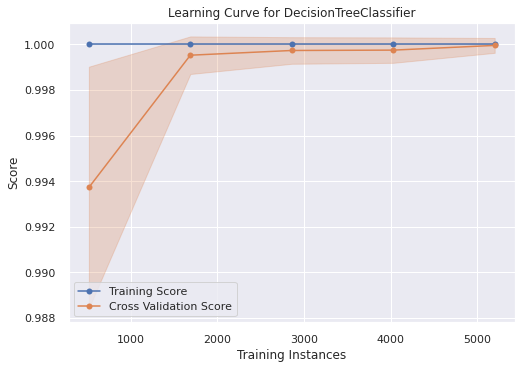

In [308]:
scores, fig, dt = evalCandidateModel(dt, X_train, y_train)
history = evalHistory(scores, "Decision Tree", history)
display(scores)

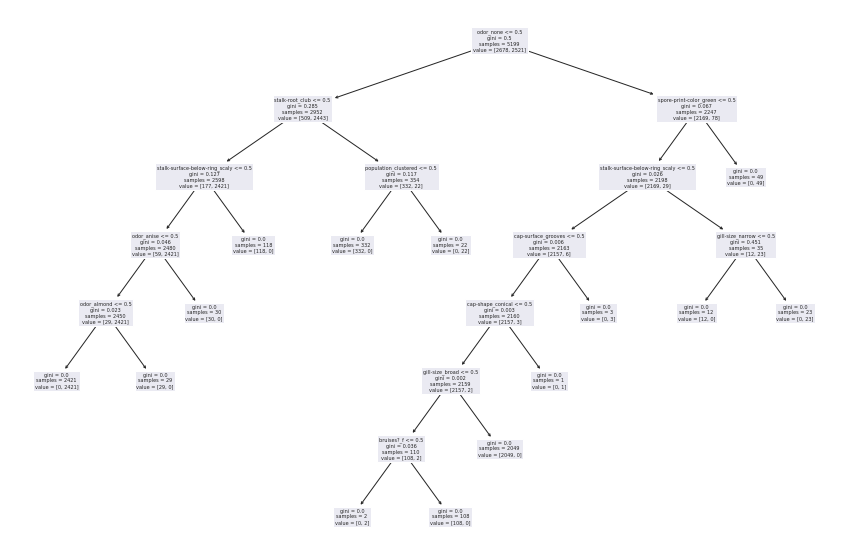

In [280]:
tree = dt[-1]
feature_names = dt[-2].get_feature_names(X.columns)
from sklearn.tree import plot_tree 
plt.figure(figsize=(15, 10))
plt_tree = plot_tree(tree, feature_names=feature_names)

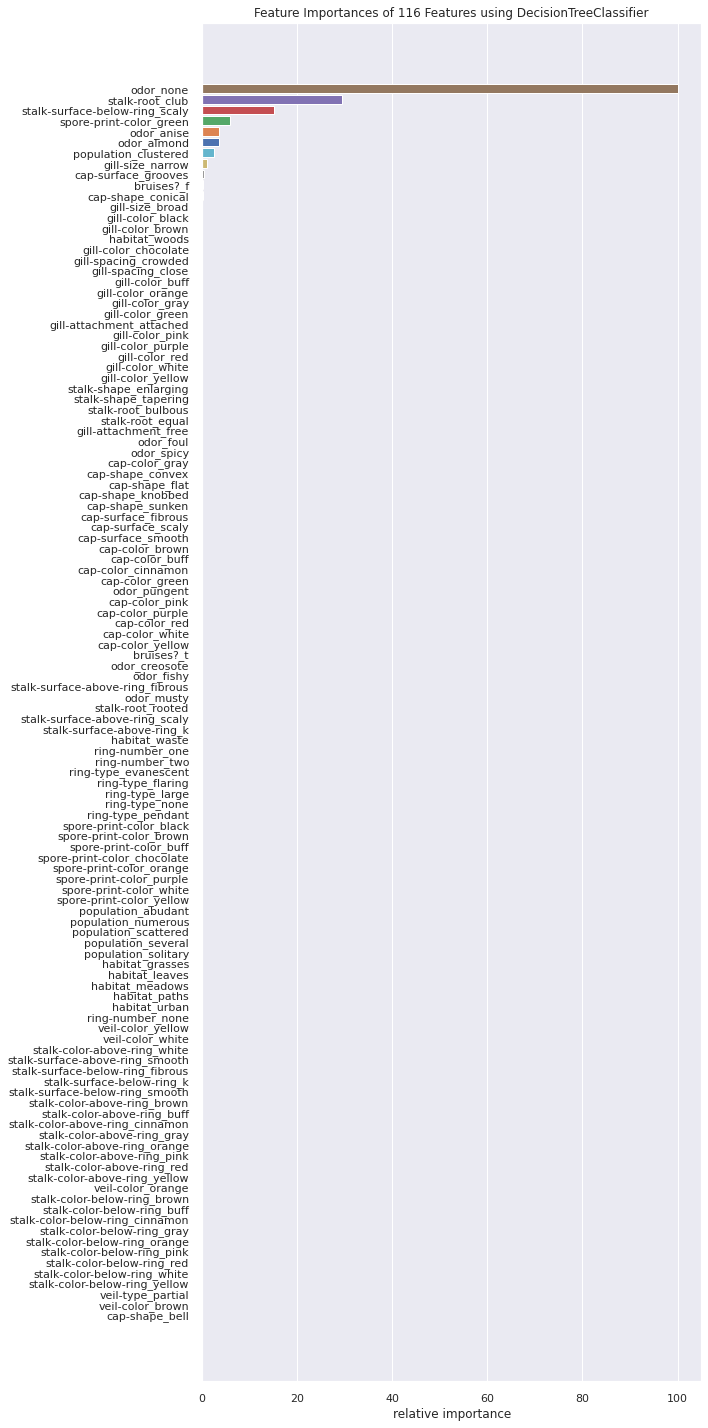

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 116 Features using DecisionTreeClassifier'}, xlabel='relative importance'>,
                   estimator=DecisionTreeClassifier(),
                   labels=array(['cap-shape_bell', 'cap-shape_conical', 'cap-shape_convex',
       'cap-shape_flat', 'cap-shape_knobbed', 'cap-shape_sunken',
       'cap-surface_fibrous', 'cap-surface_grooves', 'ca...
       'spore-print-color_green', 'spore-print-color_orange',
       'spore-print-color_purple', 'spore-print-color_white',
       'spore-print-color_yellow', 'population_abudant',
       'population_clustered', 'population_numerous',
       'population_scattered', 'population_several',
       'population_solitary', 'habitat_grasses', 'habitat_leaves',
       'habitat_meadows', 'habitat_paths', 'habitat_urban',
       'habitat_waste', 'habitat_woods'], dtype=object))

In [293]:
fig, ax = plt.subplots(figsize=(10, 20))
feature_importances(dt[-1], X_train, y_train, labels=dt[1].get_feature_names(X_train.columns), ax = ax)

## Modelling: Logistic Regression

,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy
mean,0.99981,0.99997,0.99962,0.99994,0.99982,0.99997
std,0.00047,0.00008,0.00093,0.00017,0.00045,0.00008


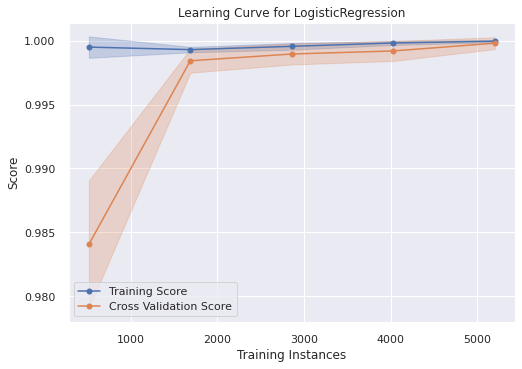

In [281]:
lr = Pipeline(data_preprocess_steps + [
    ('Model', LogisticRegression())
])
scores, fig, lr = evalCandidateModel(lr, X_train, y_train)
history = evalHistory(scores, "Logistic Regression", history)
display(scores)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


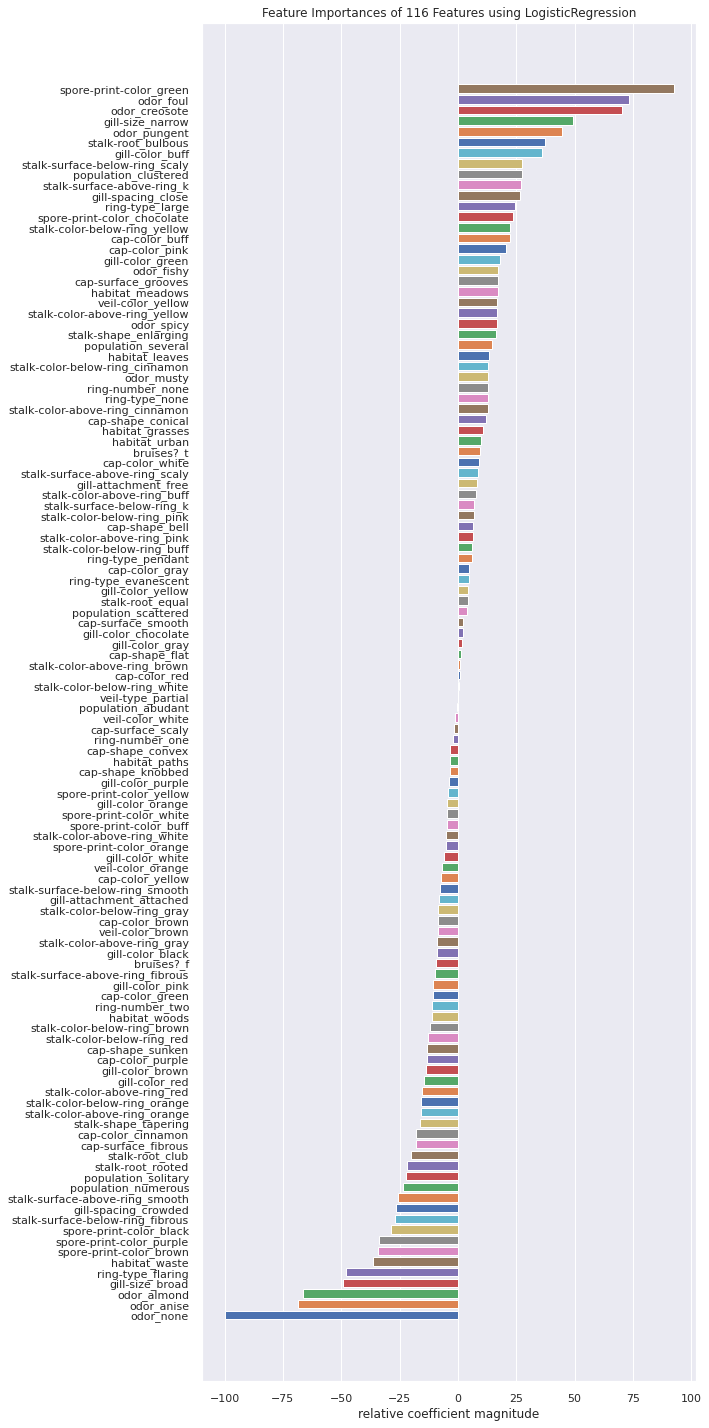

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 116 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>,
                   estimator=LogisticRegression(),
                   labels=array(['cap-shape_bell', 'cap-shape_conical', 'cap-shape_convex',
       'cap-shape_flat', 'cap-shape_knobbed', 'cap-shape_sunken',
       'cap-surface_fibrous', 'cap-surface_grooves', '...
       'spore-print-color_green', 'spore-print-color_orange',
       'spore-print-color_purple', 'spore-print-color_white',
       'spore-print-color_yellow', 'population_abudant',
       'population_clustered', 'population_numerous',
       'population_scattered', 'population_several',
       'population_solitary', 'habitat_grasses', 'habitat_leaves',
       'habitat_meadows', 'habitat_paths', 'habitat_urban',
       'habitat_waste', 'habitat_woods'], dtype=object))

In [291]:

fig, ax = plt.subplots(figsize=(10, 20))
feature_importances(lr[-1], X_train, y_train, labels=lr[1].get_feature_names(X_train.columns), ax = ax)

### Regularized Logistic Regression (L1)


,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy
mean,0.99994,0.99999,0.99988,0.99998,0.99994,0.99999
std,0.00044,0.00009,0.00087,0.00017,0.00044,0.00008


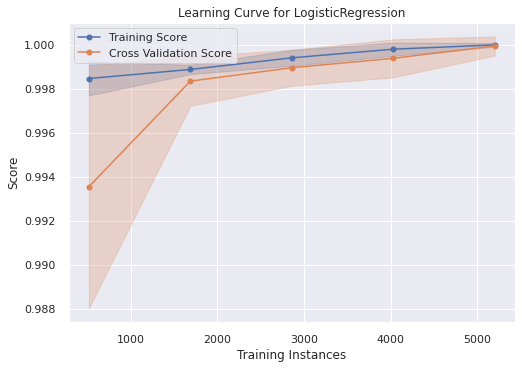

In [296]:
lr = Pipeline(data_preprocess_steps + [
    ('Model', LogisticRegression(solver='liblinear', penalty='l1'))
])
scores, fig, lr = evalCandidateModel(lr, X_train, y_train)
history = evalHistory(scores, "Logistic Regression (L1 Regularization)", history)
display(scores)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/yellowbrick/model_selection/importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


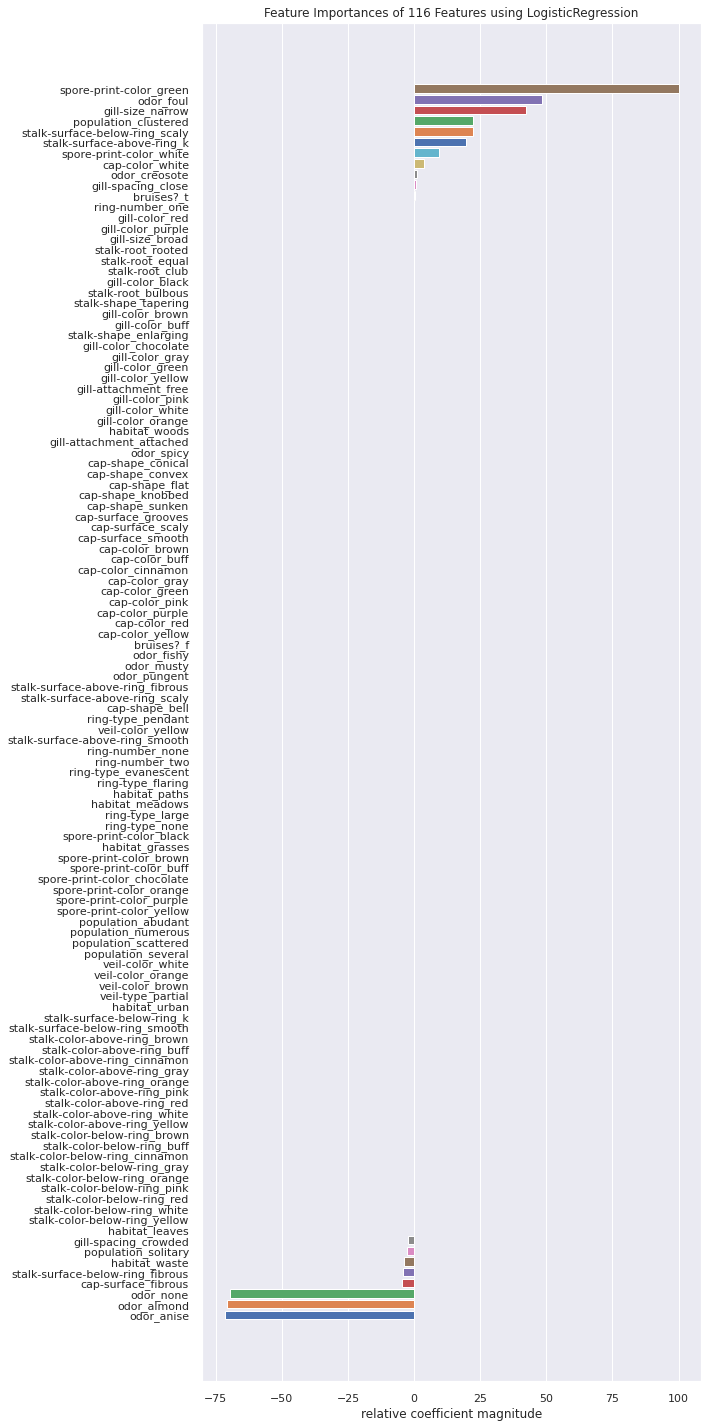

FeatureImportances(ax=<AxesSubplot:title={'center':'Feature Importances of 116 Features using LogisticRegression'}, xlabel='relative coefficient magnitude'>,
                   estimator=LogisticRegression(penalty='l1',
                                                solver='liblinear'),
                   labels=array(['cap-shape_bell', 'cap-shape_conical', 'cap-shape_convex',
       'cap-shape_flat', 'cap-shape_knobbed', 'cap-shape_sunken',
       'cap-surface_f...
       'spore-print-color_green', 'spore-print-color_orange',
       'spore-print-color_purple', 'spore-print-color_white',
       'spore-print-color_yellow', 'population_abudant',
       'population_clustered', 'population_numerous',
       'population_scattered', 'population_several',
       'population_solitary', 'habitat_grasses', 'habitat_leaves',
       'habitat_meadows', 'habitat_paths', 'habitat_urban',
       'habitat_waste', 'habitat_woods'], dtype=object))

In [297]:

fig, ax = plt.subplots(figsize=(10, 20))
feature_importances(lr[-1], X_train, y_train, labels=lr[1].get_feature_names(X_train.columns), ax = ax)

## Modelling: Naive Bayes

,test_f1,train_f1,test_recall,train_recall,test_accuracy,train_accuracy
mean,0.94764,0.94875,0.90863,0.90983,0.95162,0.95260
std,0.00646,0.00207,0.01102,0.00360,0.00572,0.00187


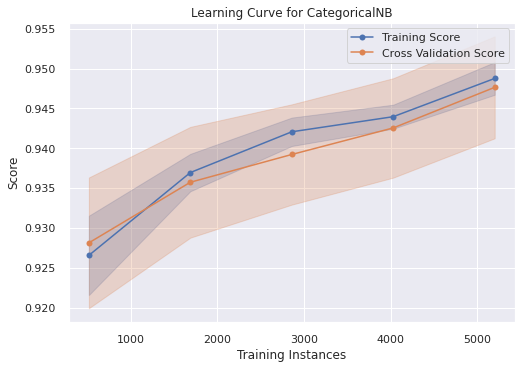

In [310]:
data_preprocess_steps_nb = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='ignore')) # ordinal encode data to allow hist gradient booster to process categorical features natively
]
nb = Pipeline(data_preprocess_steps_nb + [
    ('Model', CategoricalNB())
])
scores, fig, nb = evalCandidateModel(nb, X_train, y_train)
history = evalHistory(scores, "Naive Bayes", history)
display(scores)

In [317]:
nb[-1]

CategoricalNB()

In [299]:
history.sort_values("test_f1", ascending=False)

,test_accuracy,test_f1,test_recall,train_accuracy,train_f1,train_recall
Decision Tree,0.99995,0.99995,0.99991,1.00000,1.00000,1.00000
Logistic Regression (L1 Regularization),0.99994,0.99994,0.99988,0.99999,0.99999,0.99998
Logistic Regression,0.99982,0.99981,0.99962,0.99997,0.99997,0.99994
Baseline (Mode Predictor),0.51777,0.00000,0.00000,0.51777,0.00000,0.00000
Logistic Regression (L1 Regularization),NaN,NaN,NaN,NaN,NaN,NaN
Logistic Regression (L1 Regularization),NaN,NaN,NaN,NaN,NaN,NaN


### Next Steps
A Decision Tree or Regularized Logistic Regression Performs well on the dataset. If we use a logistic regression model with L1 regularization, feature selection would be less necessary.

#### Making the Model More Applicable 
- While our models may perform well, how applicable is it in the real world? Certain features used by these models may be difficult to determine in the field, limiting the utility of the model. Is it possible to do feature engineering to simplify similar features?

#### Feature Selection
- Due to the high cardinality of each categorical variable, our dataset has an extremely high dimensionality. This makes our learning algorithms more prone to overfitting. Hence, it would be preferable if our models were trained on a smaller subset of features.


In [135]:
X

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,convex,smooth,brown,t,pungent,free,close,narrow,black,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
1,convex,smooth,yellow,t,almond,free,close,broad,black,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,grasses
2,bell,smooth,white,t,anise,free,close,broad,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,brown,numerous,meadows
3,convex,scaly,white,t,pungent,free,close,narrow,brown,enlarging,...,smooth,white,white,partial,white,one,pendant,black,scattered,urban
4,convex,smooth,gray,f,none,free,crowded,broad,black,tapering,...,smooth,white,white,partial,white,one,evanescent,brown,abudant,grasses
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,knobbed,smooth,brown,f,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8120,convex,smooth,brown,f,none,attached,close,broad,yellow,enlarging,...,smooth,orange,orange,partial,brown,one,pendant,buff,several,leaves
8121,flat,smooth,brown,f,none,attached,close,broad,brown,enlarging,...,smooth,orange,orange,partial,orange,one,pendant,buff,clustered,leaves
8122,knobbed,scaly,brown,f,fishy,free,close,narrow,buff,tapering,...,k,white,white,partial,white,one,evanescent,white,several,leaves


In [ ]:
We start by creating a transformer to remove features with low variance (have almost the same value for all rows), as they are unlikely to be useful predictors. 

In [348]:
class CatVarianceThreshold(BaseEstimator, TransformerMixin):
    def __init__(self, variance_threshold = 0.05, labels = None):
        self.threshold = 1 - variance_threshold
        self.labels = labels
    def fit(self, X, y = None):
        if self.labels is not None:
            X = pd.DataFrame(X, columns = labels)
        self.low_var_features = dict(zip(X.columns,((X.apply(lambda x : (x.value_counts() / len(X)).max(), axis = 0)) >= self.threshold).values))
        return self
    def transform(self, X, y = None):
        if self.labels is not None:
            X = pd.DataFrame(X, columns = labels)
        return X[[feature for feature, drop in self.low_var_features.items() if not drop]]
CatVarianceThreshold().fit_transform(X_train)

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-number,ring-type,spore-print-color,population,habitat
7873,knobbed,smooth,red,f,spicy,close,narrow,buff,tapering,NaN,smooth,k,pink,white,one,evanescent,white,several,woods
6515,convex,smooth,brown,f,foul,close,narrow,buff,tapering,NaN,k,smooth,white,white,one,evanescent,white,several,paths
6141,flat,scaly,red,f,fishy,close,narrow,buff,tapering,NaN,smooth,smooth,pink,white,one,evanescent,white,several,leaves
2764,flat,fibrous,brown,t,none,close,broad,purple,tapering,bulbous,smooth,smooth,gray,pink,one,pendant,brown,several,woods
438,bell,scaly,yellow,t,anise,close,broad,black,enlarging,club,smooth,smooth,white,white,one,pendant,brown,numerous,meadows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,convex,scaly,brown,f,foul,close,narrow,buff,tapering,NaN,k,smooth,pink,white,one,evanescent,white,several,paths
5390,knobbed,scaly,red,t,none,close,broad,white,enlarging,NaN,smooth,smooth,white,red,two,evanescent,white,clustered,waste
860,flat,scaly,brown,t,anise,close,broad,white,enlarging,rooted,smooth,scaly,white,white,one,pendant,brown,solitary,paths
7603,knobbed,smooth,red,f,foul,close,narrow,buff,tapering,NaN,smooth,smooth,pink,pink,one,evanescent,white,several,paths


#### Feature Importances
To calculate feature importances, we will make use of permutation based feature importance. This is because impurity based feature importances used in tree-based models are highly biased towards high cardinality features, and do not reflect the ability of the feature to be useful for generalization. Since permutation importance still has issues for highly correlated features, we will first filter out features that have a high $\phi k$ correlation with each other, before calculating permutation importances.

##### Removing Correlated Features
We will perform hierachical clustering based on correlation to cluster correlated features together, and pick a feature to retain from each cluster.

In [349]:
X_train_reduced = CatVarianceThreshold().fit_transform(X_train)
X_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6499 entries, 7873 to 7270
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 6499 non-null   object
 1   cap-surface               6499 non-null   object
 2   cap-color                 6499 non-null   object
 3   bruises?                  6499 non-null   object
 4   odor                      6499 non-null   object
 5   gill-spacing              6499 non-null   object
 6   gill-size                 6499 non-null   object
 7   gill-color                6499 non-null   object
 8   stalk-shape               6499 non-null   object
 9   stalk-root                4492 non-null   object
 10  stalk-surface-above-ring  6499 non-null   object
 11  stalk-surface-below-ring  6499 non-null   object
 12  stalk-color-above-ring    6499 non-null   object
 13  stalk-color-below-ring    6499 non-null   object
 14  ring-number          

In [351]:
mush_corr = X_train_reduced.phik_matrix()

### Calculating Permutation Importances
We make use of sklearn's implementation of LightGBM, which includes native support for nominal variables.

In [138]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('OrdinalEncoder', OrdinalEncoder(handle_unknown='ignore')) # ordinal encode data to allow hist gradient booster to process categorical features natively
]
data_preprocessing = Pipeline(data_preprocess_steps)

,test_score,train_score,hold_out_score
mean,1.0,1.0,1.0
std,0.0,0.0,0.0


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



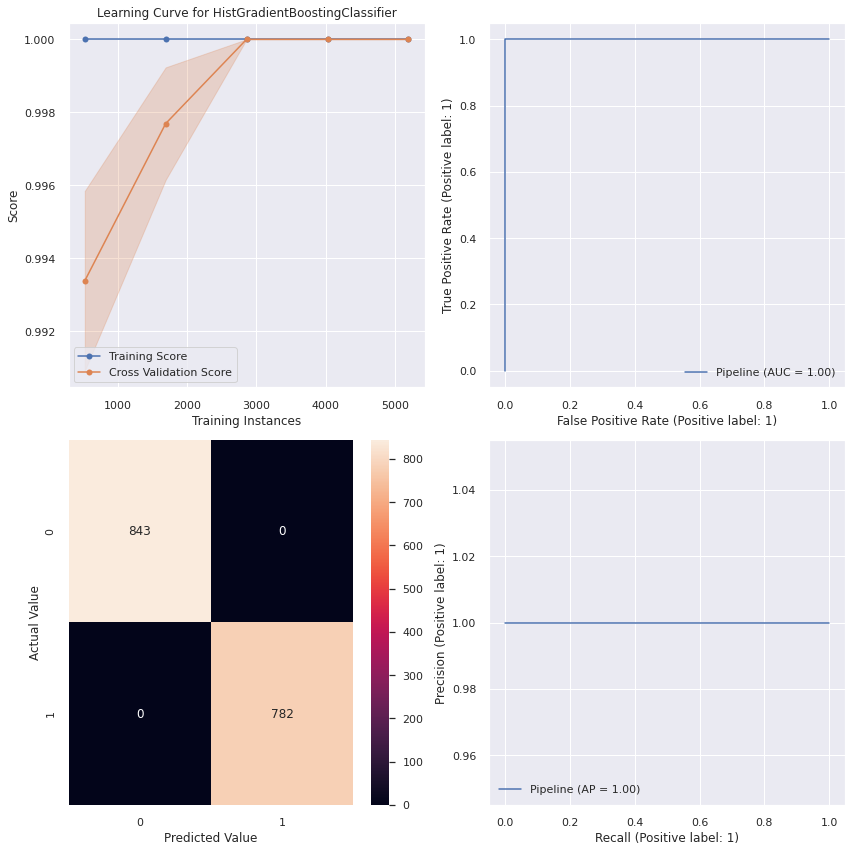

In [139]:
clf = Pipeline(data_preprocess_steps + [
    ('Gradient Boosted Trees Model', HistGradientBoostingClassifier(categorical_features = [True] * len(X_train.columns), max_depth = 5))
])
scores,report, fig, gbm = evalCandidateModel(clf, X_train, X_test, y_train, y_test)
history = evalHistory(scores, "LightGBM", history)
display(scores)
print(report)

In [140]:
result = permutation_importance(gbm, X_test, y_test, n_repeats= 10, random_state = 42, n_jobs = -1)
result


{'importances_mean': array([0.00000000e+00, 0.00000000e+00, 4.92307692e-04, 0.00000000e+00,
        4.88676923e-01, 5.90769231e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 6.15384615e-05, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 1.37846154e-02, 4.30769231e-04,
        0.00000000e+00]),
 'importances_std': array([0.        , 0.        , 0.00024615, 0.        , 0.0131279 ,
        0.00138154, 0.        , 0.        , 0.        , 0.00018462,
        0.        , 0.        , 0.        , 0.        , 0.00132558,
        0.000282  , 0.        ]),
 'importances': array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.00061538, 0.00061538, 0.00061538, 0.00061538, 0.00061538,
         0.        , 0.00061538, 0.        , 0.

In [141]:
pd.DataFrame(np.array([result.importances_mean, result.importances_std]).T, columns=["Mean FI", "FI STD"], index=X_train.columns).sort_values("Mean FI", ascending = False)

,Mean FI,FI STD
odor,0.488677,0.013128
spore-print-color,0.013785,0.001326
gill-size,0.005908,0.001382
cap-color,0.000492,0.000246
population,0.000431,0.000282
stalk-surface-above-ring,0.000062,0.000185
cap-shape,0.000000,0.000000
stalk-color-above-ring,0.000000,0.000000
ring-type,0.000000,0.000000
stalk-color-below-ring,0.000000,0.000000


We note that odor has the highest mean decrease in accuracy when it's values are randomly shuffled, suggesting it is the most important feature. This is followed by spore-print-color, and gill size. The mean feature importance of odor is much higher than all other features. This suggests that this feature has the best generalization.

In [142]:
phik_overview.nlargest(10, "class")

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
class,1.000000,0.339560,0.294330,0.281663,0.708427,0.931449,0.199636,0.519680,0.749777,0.838625,...,0.795807,0.783006,0.522229,0.512312,0.229215,0.129640,0.496840,0.737545,0.665121,0.410200
odor,0.931449,0.452134,0.358378,0.607339,0.653013,1.000000,0.260271,0.428422,0.744987,0.700349,...,0.583373,0.675120,0.862285,0.859799,0.155551,0.952736,0.846142,0.819423,0.630450,0.597233
gill-color,0.838625,0.524641,0.506619,0.568713,0.807167,0.700349,0.926703,0.416612,0.929546,1.000000,...,0.649711,0.680309,0.731246,0.727520,0.764312,0.723609,0.730589,0.787076,0.780714,0.719181
stalk-surface-above-ring,0.795807,0.242318,0.350663,0.407822,0.783349,0.583373,0.139788,0.628530,0.254215,0.649711,...,1.000000,0.839322,0.683801,0.601291,0.695746,0.134823,0.526466,0.586382,0.464642,0.417704
stalk-surface-below-ring,0.783006,0.168853,0.407656,0.495496,0.774913,0.675120,0.185772,0.600232,0.225441,0.680309,...,0.839322,1.000000,0.622198,0.631167,0.292244,0.267124,0.591786,0.589179,0.470218,0.429951
gill-size,0.749777,0.479438,0.412216,0.606414,0.547950,0.744987,0.168185,0.167915,1.000000,0.929546,...,0.254215,0.225441,0.364941,0.346026,0.169454,0.117523,0.469395,0.652801,0.702558,0.465152
spore-print-color,0.737545,0.460748,0.350068,0.545442,0.606991,0.819423,0.803236,0.307347,0.652801,0.787076,...,0.586382,0.589179,0.836237,0.832583,0.669123,0.653267,0.742690,1.000000,0.533221,0.543044
bruises?,0.708427,0.353524,0.200454,0.280636,1.000000,0.653013,0.212208,0.452514,0.547950,0.807167,...,0.783349,0.774913,0.481338,0.490808,0.199829,0.041795,0.639604,0.606991,0.415869,0.494364
population,0.665121,0.576710,0.390325,0.517833,0.415869,0.630450,0.570228,0.864630,0.702558,0.780714,...,0.464642,0.470218,0.680276,0.676804,0.342064,0.738902,0.470283,0.533221,1.000000,0.694694
stalk-color-above-ring,0.522229,0.401862,0.378182,0.530818,0.481338,0.862285,0.938937,0.399950,0.364941,0.731246,...,0.683801,0.622198,1.000000,0.949868,0.896146,0.963143,0.830963,0.836237,0.680276,0.651509


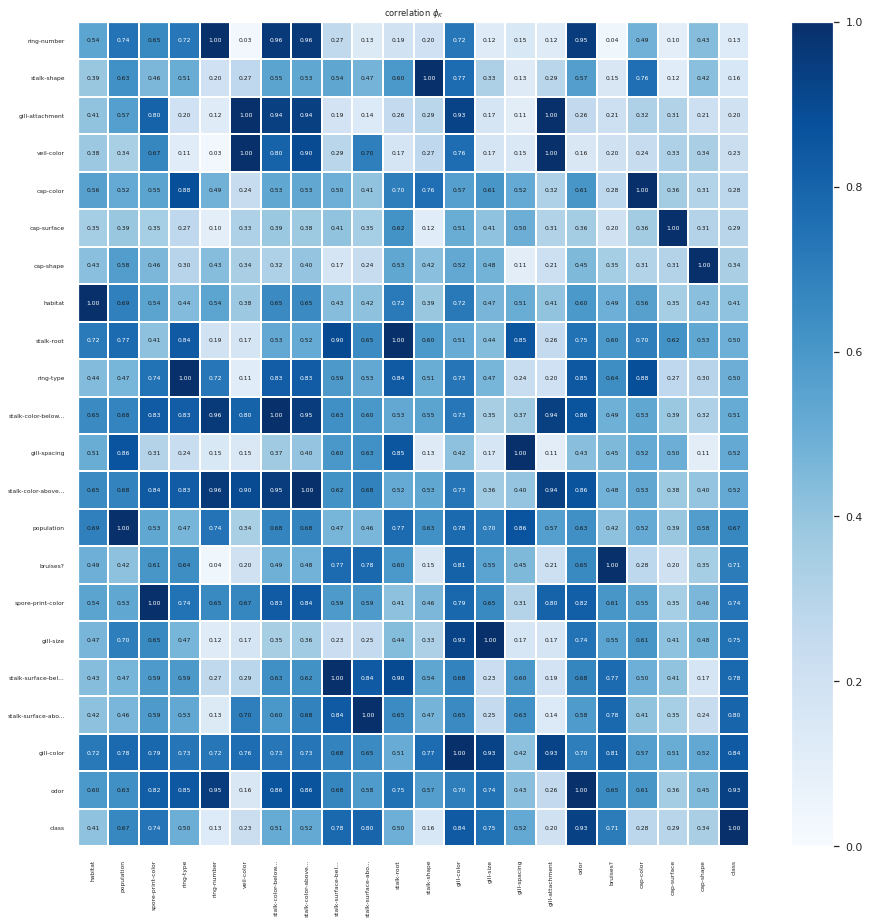

In [143]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=0.6,
                        figsize=(13,13))
plt.tight_layout()

Odor being the most important is also supported by our $\phi_k$ correlation matrix, in which odor has 0.93 correlation.

### Feature Selection
Based off these feature importances and the correlation matrix, we will restrict our features. We exclude spore print color, since from our background research, we've found that it is difficult to get spore print color.

In [144]:
features = ["odor", "gill-color", "stalk-surface-above-ring", "stalk-surface-below-ring", "gill-size", "bruises?", "population"]

In [145]:
X_train[features]

,odor,gill-color,stalk-surface-above-ring,stalk-surface-below-ring,gill-size,bruises?,population
7873,spicy,buff,smooth,k,narrow,f,several
6515,foul,buff,k,smooth,narrow,f,several
6141,fishy,buff,smooth,smooth,narrow,f,several
2764,none,purple,smooth,smooth,broad,t,several
438,anise,black,smooth,smooth,broad,t,numerous
...,...,...,...,...,...,...,...
5226,foul,buff,k,smooth,narrow,f,several
5390,none,white,smooth,smooth,broad,t,clustered
860,anise,white,smooth,scaly,broad,t,solitary
7603,foul,buff,smooth,smooth,narrow,f,several


,test_score,train_score,hold_out_score
mean,0.99677,0.99677,0.99815
std,0.00126,0.00032,0.00000


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       843
           1       1.00      1.00      1.00       782

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



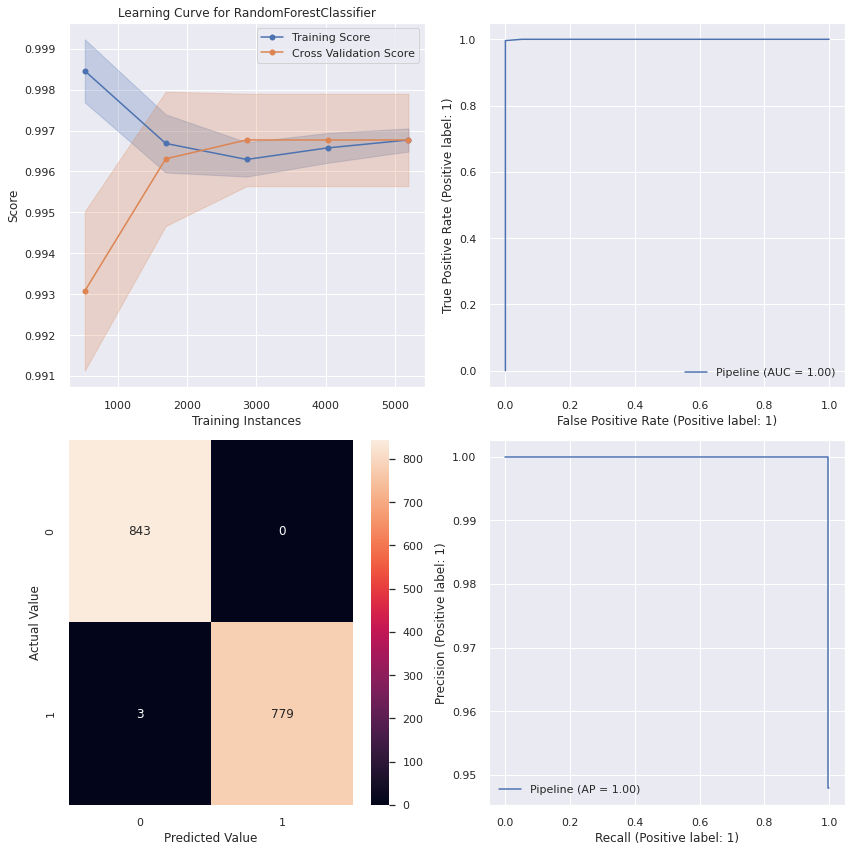

In [146]:
# data_preprocess_steps = [
#     ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
#     ('OneHotEncoder', OneHotEncoder(handle_unknown='ignore')) # one hot encode categorical data. We don't drop for other catergorical features as we want to make the features more interpretible (at cost to having extra dimensions in the data)
# ]
X_train_ohe = pd.get_dummies(X_train[features])
X_test_ohe = pd.get_dummies(X_test[features])
X_train_ohe,X_test_ohe = X_train_ohe.align(X_test_ohe, join='outer', axis=1, fill_value=0)
clf = Pipeline(
    [('Random Forest Model', RandomForestClassifier())]
)

scores,report, fig, rf = evalCandidateModel(clf,X_train_ohe, X_test_ohe, y_train, y_test)
history = evalHistory(scores, "Random Forest Model", history)
display(scores)
print(report)

In [147]:
result = permutation_importance(rf, X_test_ohe, y_test, n_repeats= 10, random_state = 42, n_jobs = -1)
result


{'importances_mean': array([0.00055385, 0.00141538, 0.        , 0.        , 0.02978462,
        0.        , 0.12012308, 0.00996923, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.01150769, 0.00455385,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00344615, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.00326154, 0.        ]),
 'importances_std': array([0.00033139, 0.00099418, 0.        , 0.        , 0.00252533,
        0.        , 0.0058691 , 0.00046051, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.00192744, 0.00068526,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.00073846,

In [148]:
fi = pd.DataFrame(np.array([result.importances_mean, result.importances_std]).T, columns=["Mean FI", "FI STD"], index=X_test_ohe.columns).sort_values("Mean FI", ascending = False)
fi.nlargest(10, "Mean FI" )

,Mean FI,FI STD
odor_none,0.120123,0.005869
odor_foul,0.029785,0.002525
gill-color_gray,0.011508,0.001927
odor_pungent,0.009969,0.000461
gill-color_green,0.004554,0.000685
gill-size_narrow,0.003446,0.000738
population_several,0.003262,0.001350
odor_anise,0.001415,0.000994
odor_almond,0.000554,0.000331
stalk-surface-below-ring_fibrous,0.000000,0.000000


In [149]:
selected_features = list(fi.nlargest(10, "Mean FI").index)
selected_features

['odor_none',
 'odor_foul',
 'gill-color_gray',
 'odor_pungent',
 'gill-color_green',
 'gill-size_narrow',
 'population_several',
 'odor_anise',
 'odor_almond',
 'stalk-surface-below-ring_fibrous']

In [150]:
class OneHotFeatureSelection(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names, selected_features):
        self.feature_names = feature_names
        self.selected_features = selected_features
        self.one = OneHotEncoder(handle_unknown='ignore', sparse=False)
    def fit(self, X, y = None):
        self.one.fit(X)
        return self
    def transform(self, X, y = None):
        X_ = self.one.transform(X)
        X_ = pd.DataFrame(X_, columns=self.one.get_feature_names(self.feature_names))
        X_ = X_[self.selected_features]
        return X_
    
OneHotFeatureSelection(features, selected_features).fit_transform(X_train[features])

,odor_none,odor_foul,gill-color_gray,odor_pungent,gill-color_green,gill-size_narrow,population_several,odor_anise,odor_almond,stalk-surface-below-ring_fibrous
0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
6494,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
6495,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6496,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6497,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0


In [151]:
data_preprocess_steps = [
    ('Imputer', SimpleImputer(strategy='most_frequent')), # impute missing values with most frequent value
    ('Encode and Drop', OneHotFeatureSelection(features, selected_features))
]

,test_score,train_score,hold_out_score
mean,0.99108,0.99108,0.99138
std,0.00222,0.00055,0.00000


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       843
           1       1.00      0.98      0.99       782

    accuracy                           0.99      1625
   macro avg       0.99      0.99      0.99      1625
weighted avg       0.99      0.99      0.99      1625



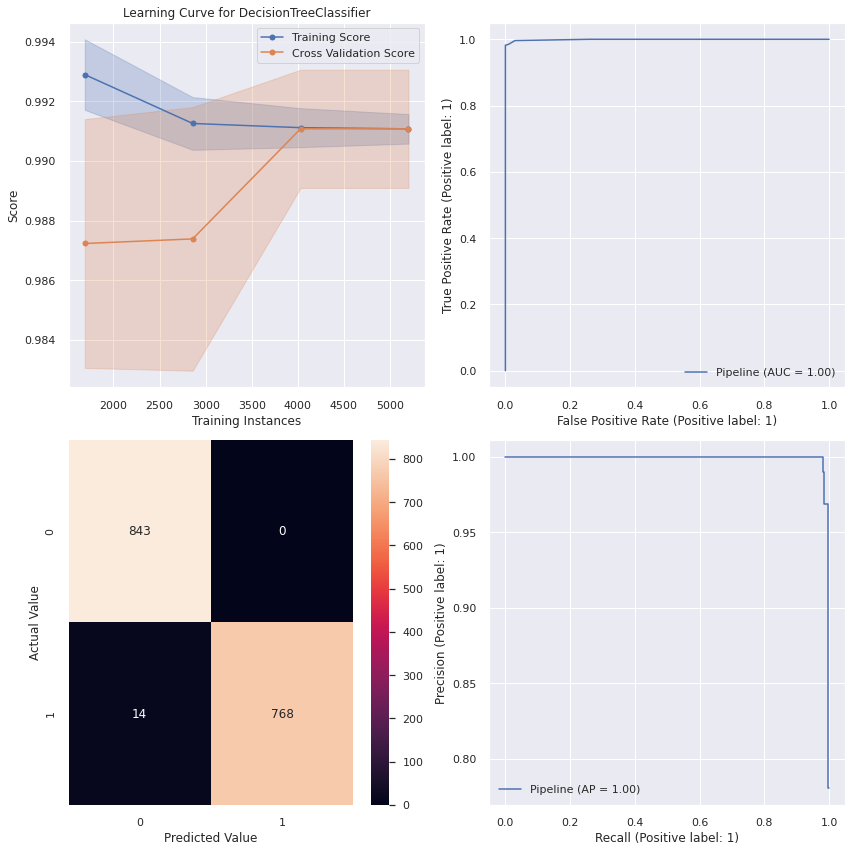

In [152]:
clf = Pipeline(data_preprocess_steps + [
    ('DT Model', DecisionTreeClassifier())
])

scores,report, fig, dt = evalCandidateModel(clf,X_train[features], X_test[features], y_train, y_test)
history = evalHistory(scores, "Decision Tree (after FS)", history)
display(scores)
print(report)

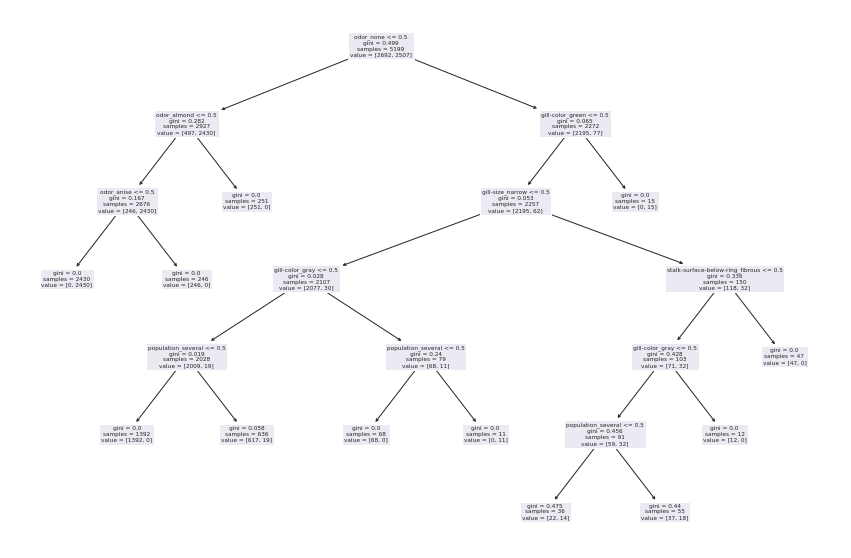

In [153]:
tree = dt[-1]
# feature_names = dt[-2].get_feature_names(X.columns)
from sklearn.tree import plot_tree 
plt.figure(figsize=(15, 10))
plt_tree = plot_tree(tree, feature_names = selected_features)

In [156]:
history.sort_values("test_score", ascending=False)

,hold_out_score,test_score,train_score
LightGBM,1.00000,1.00000,1.00000
Decision Tree (Max Depth = 5),1.00000,0.99815,0.99888
Random Forest Model,0.99815,0.99677,0.99677
Decision Tree (after FS),0.99138,0.99108,0.99108
Decision Tree (Max Depth = 2),0.94400,0.94999,0.95211
Baseline (Mode Predictor),0.51877,0.51777,0.51777


### Hyperparameter Tuning
- We will build a validation curve to determine the lowest complexity of the model needed to meet our initial objectives.

In [158]:
X_train

,cap-shape,cap-surface,cap-color,bruises?,odor,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,ring-type,spore-print-color,population,habitat
7873,knobbed,smooth,red,f,spicy,narrow,buff,tapering,NaN,smooth,k,pink,white,evanescent,white,several,woods
6515,convex,smooth,brown,f,foul,narrow,buff,tapering,NaN,k,smooth,white,white,evanescent,white,several,paths
6141,flat,scaly,red,f,fishy,narrow,buff,tapering,NaN,smooth,smooth,pink,white,evanescent,white,several,leaves
2764,flat,fibrous,brown,t,none,broad,purple,tapering,bulbous,smooth,smooth,gray,pink,pendant,brown,several,woods
438,bell,scaly,yellow,t,anise,broad,black,enlarging,club,smooth,smooth,white,white,pendant,brown,numerous,meadows
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5226,convex,scaly,brown,f,foul,narrow,buff,tapering,NaN,k,smooth,pink,white,evanescent,white,several,paths
5390,knobbed,scaly,red,t,none,broad,white,enlarging,NaN,smooth,smooth,white,red,evanescent,white,clustered,waste
860,flat,scaly,brown,t,anise,broad,white,enlarging,rooted,smooth,scaly,white,white,pendant,brown,solitary,paths
7603,knobbed,smooth,red,f,foul,narrow,buff,tapering,NaN,smooth,smooth,pink,pink,evanescent,white,several,paths


,test_score,train_score,hold_out_score
mean,0.86890,0.86890,0.86462
std,0.01245,0.00311,0.00000


              precision    recall  f1-score   support

           0       1.00      0.74      0.85       843
           1       0.78      1.00      0.88       782

    accuracy                           0.86      1625
   macro avg       0.89      0.87      0.86      1625
weighted avg       0.89      0.86      0.86      1625



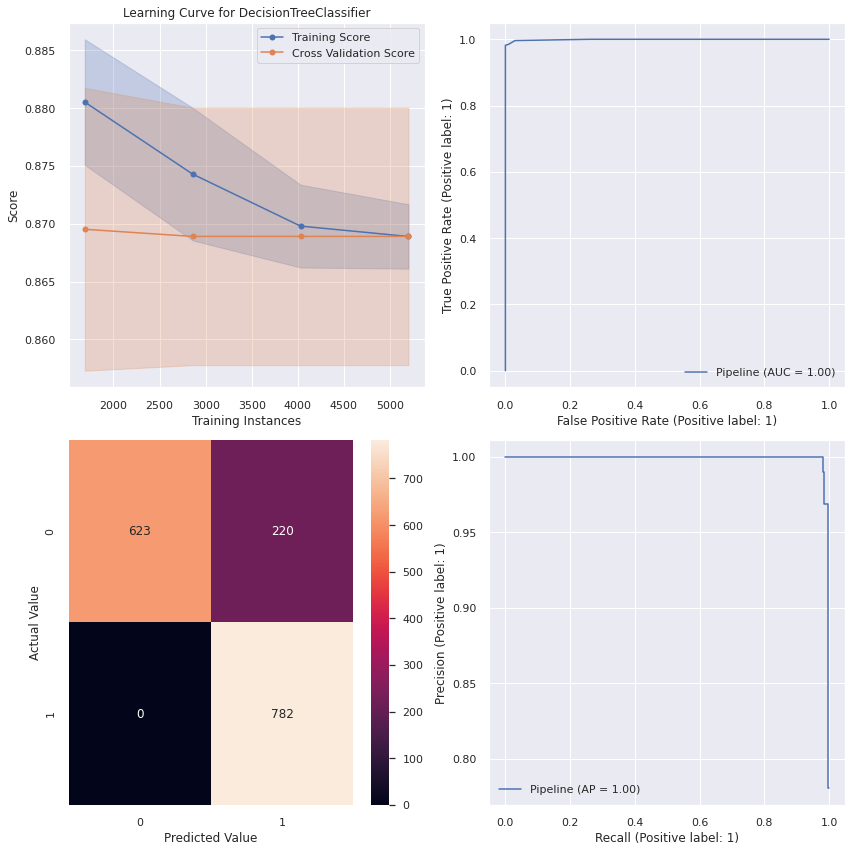

In [170]:
clf = Pipeline(data_preprocess_steps + [
    ('DT Model', DecisionTreeClassifier(class_weight = {
        1 : 50,
        0: 1
    }))
])

scores,report, fig, dt = evalCandidateModel(clf,X_train[features], X_test[features], y_train, y_test)
history = evalHistory(scores, "Decision Tree (after FS)", history)
display(scores)
print(report)

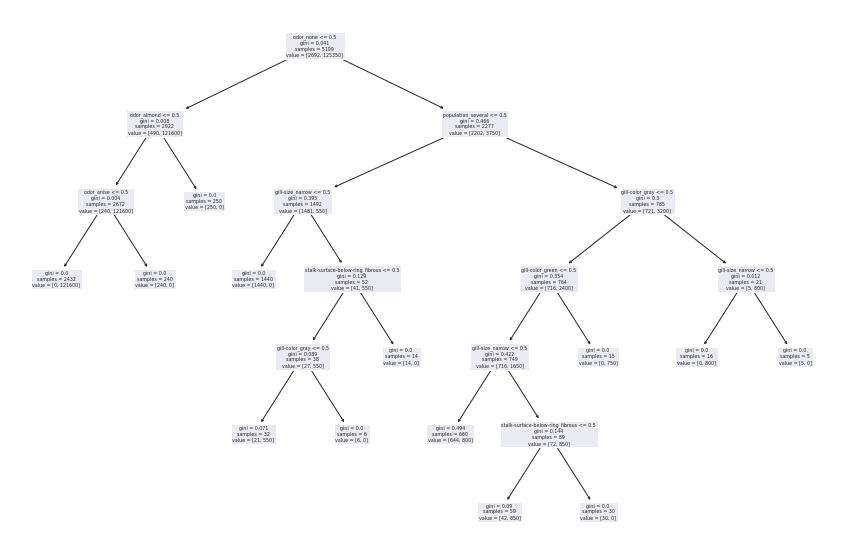

In [171]:
tree = dt[-1]
# feature_names = dt[-2].get_feature_names(X.columns)

plt.figure(figsize=(15, 10))
plt_tree = plot_tree(tree, feature_names = selected_features)